In [17]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
torch.manual_seed(42)

from class_variation_intensity_optimization import DipoleSimulation
# Importation des fonctions pour obtenir le tenseur W3 et calculer la Fisher information
from fisher_functions import get_W3, fisher


# 1. Simulation et obtention des TM


# Paramètres#thet = 0              # incidence normale (0 radians)
N_obs_x = 100         # résolution en x pour compute_field
N_obs_y = 300         # résolution en y pour compute_field
# Ici, Nb_input_modes correspond au nombre d'angles qu'on utilise pour construire la TM
Nb_input_modes = 50

# Création de l'instance de DipoleSimulation
sim = DipoleSimulation(Nb_particule=150, W=3, L=1, k_in=25, N_x=100, N_y=300)







In [18]:
# Obtention des TM et preparation pour obtenir W3

theta_vals = np.linspace(-np.pi/5, np.pi/5, Nb_input_modes)

# TM de référence 
# build_TM boucle sur les angles et renvoie un tableau de forme (Nb_input_modes, N_obs_y)
TM_ref_all = sim.build_TM(theta_vals, N_obs_x, N_obs_y)
# attention j'ai mal défini la fonction build_TM, il faut transposer pour avoir la vraie tm
TM_ref_mat = TM_ref_all.T  # shape : (Nb_output_modes, Nb_input_modes)

# TM de calibration (petit déplacement connu) 
ksi_calib = sim.L / sim.N_y  
sim_calib = copy.deepcopy(sim)
sim_calib.deplacement_particule(index=50, ksi=ksi_calib)
TM_calib_all = sim_calib.build_TM(theta_vals, N_obs_x, N_obs_y)
TM_calib_mat = TM_calib_all.T  # shape : (Nb_output_modes, Nb_input_modes)

# Définir Nb_output_modes comme le nombre de pixels observés (ici, N_obs_y)
Nb_output_modes = TM_ref_mat.shape[0]
print('le nombre de output modes est ',  Nb_output_modes)
print("TM_ref_mat shape:", TM_ref_mat.shape)       # par exemple, (300, 25)
print("TM_calib_mat shape:", TM_calib_mat.shape)

# Empiler les deux états pour constituer le tenseur utilisé par get_W3
TMs4modes = np.stack([TM_ref_mat, TM_calib_mat], axis=0)  # forme : (2, Nb_output_modes, Nb_input_modes)
print("TMs4modes shape:", TMs4modes.shape)

Traitement de theta 1/50 : 2.0% terminé
Traitement de theta 2/50 : 4.0% terminé
Traitement de theta 3/50 : 6.0% terminé
Traitement de theta 4/50 : 8.0% terminé
Traitement de theta 5/50 : 10.0% terminé
Traitement de theta 6/50 : 12.0% terminé
Traitement de theta 7/50 : 14.0% terminé
Traitement de theta 8/50 : 16.0% terminé
Traitement de theta 9/50 : 18.0% terminé
Traitement de theta 10/50 : 20.0% terminé
Traitement de theta 11/50 : 22.0% terminé
Traitement de theta 12/50 : 24.0% terminé
Traitement de theta 13/50 : 26.0% terminé
Traitement de theta 14/50 : 28.0% terminé
Traitement de theta 15/50 : 30.0% terminé
Traitement de theta 16/50 : 32.0% terminé
Traitement de theta 17/50 : 34.0% terminé
Traitement de theta 18/50 : 36.0% terminé
Traitement de theta 19/50 : 38.0% terminé
Traitement de theta 20/50 : 40.0% terminé
Traitement de theta 21/50 : 42.0% terminé
Traitement de theta 22/50 : 44.0% terminé
Traitement de theta 23/50 : 46.0% terminé
Traitement de theta 24/50 : 48.0% terminé
Trait

TM shape est (300, 50)


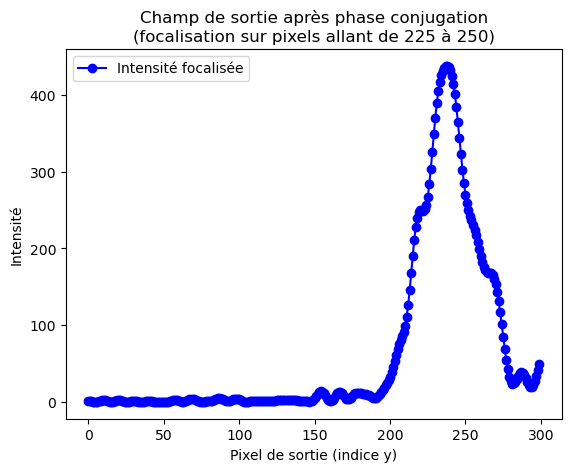

In [26]:
# rajouter phase conjugation pour verifier que les tm sont bonnes 
from class_variation_intensity_optimization import PhaseConjugation 


desired_output = np.zeros(N_obs_y, dtype=complex)
#print("desired_output_field shape is " , desired_output.shape)
numero_pixel_foca1 = 225
numero_pixel_foca2 = 250 
desired_output[numero_pixel_foca1 : numero_pixel_foca2] = 1.0

# Instanciation de l'objet de phase conjugation avec la TM pré-transposée
pc = PhaseConjugation(TM_ref_all)
#print("La forme de TM dans pc:", pc.TM.shape)


# Calcul du champ d'entrée optimal
input_field = pc.compute_input_field(desired_output)
phase_input = pc.phase_only(input_field)
#print("phase_input.shape =", phase_input.shape)


# Calcul du champ de sortie focalisé via la TM
focused_output = pc.compute_focused_output(phase_input)

# Affichage du profil d'intensité le long de la colonne de sortie (axe y)
plt.figure()
plt.plot(np.arange(N_obs_y), np.abs(focused_output)**2, 'bo-', label='Intensité focalisée')
plt.xlabel('Pixel de sortie (indice y)')
plt.ylabel('Intensité')
plt.title('Champ de sortie après phase conjugation\n(focalisation sur pixels allant de {} à {})'.format(numero_pixel_foca1, numero_pixel_foca2))

plt.legend()
plt.show()

In [ ]:
#2 Obtention MIIC 

# Calcul du tenseur W3 à partir de TMs4modes
W3 = get_W3(TMs4modes)  # W3 de forme : (Nb_output_modes, Nb_input_modes, Nb_input_modes)
print("W3 shape:", W3.shape)

# Conversion en tenseur PyTorch
W3_torch = torch.tensor(W3)
Nb_output_modes_t, Nb_input_modes_t, Nb_input_modes_t2 = W3_torch.shape
assert Nb_input_modes_t == Nb_input_modes_t2, "Les deux dernières dimensions doivent être égales."

# on met l'indice du deuxième mode en lignes et on combine le premier et le troisième indices en colonnes.
M = W3_torch.permute(1, 0, 2).reshape(Nb_input_modes_t, -1)  # forme : (Nb_input_modes, Nb_output_modes*Nb_input_modes)
U, S, Vh = torch.linalg.svd(M, full_matrices=False)


# afficher normalized svd values vs index of value (cf TENSOR_WFS_SI github rodrigo)
MIIC = U[:, 0]  # dimension : (Nb_input_modes,)
print("MIIC shape:", MIIC.shape)
MIIC_np = MIIC.numpy()
Fmiic = fisher(MIIC_np, TMs4modes)

print("Fisher Information (MIIC):", Fmiic)


W3 shape: (300, 15, 15)
MIIC shape: torch.Size([15])
Fisher Information (MIIC): 0.002194105113759226


Norme absolue de la différence : 1.140642006350867
Norme relative de la différence : 0.014104824831562194


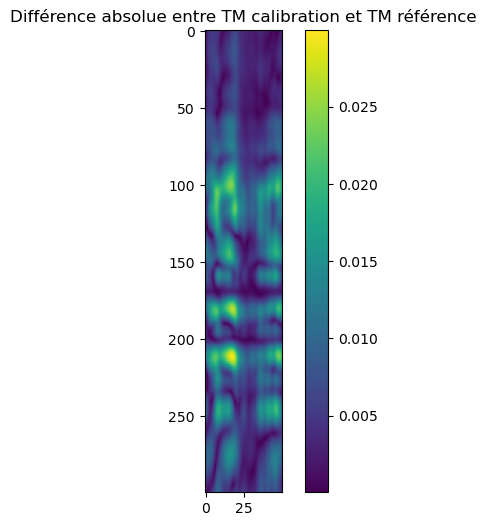

In [22]:
# Comparaison entre la TM de référence et la TM de calibration

# Calcul de la différence entre les matrices
diff_TM = TM_calib_mat - TM_ref_mat

# Calcul de la norme de la différence et de la norme de la TM de référence
norm_diff = np.linalg.norm(diff_TM)
norm_ref = np.linalg.norm(TM_ref_mat)
relative_diff = norm_diff / norm_ref

print("Norme absolue de la différence :", norm_diff)
print("Norme relative de la différence :", relative_diff)

# Affichage de la différence (module) en image
plt.figure(figsize=(6,6))
plt.imshow(np.abs(diff_TM), cmap='viridis')
plt.colorbar()
plt.title("Différence absolue entre TM calibration et TM référence")
plt.show()

fisher_opt =  21.036572416966745


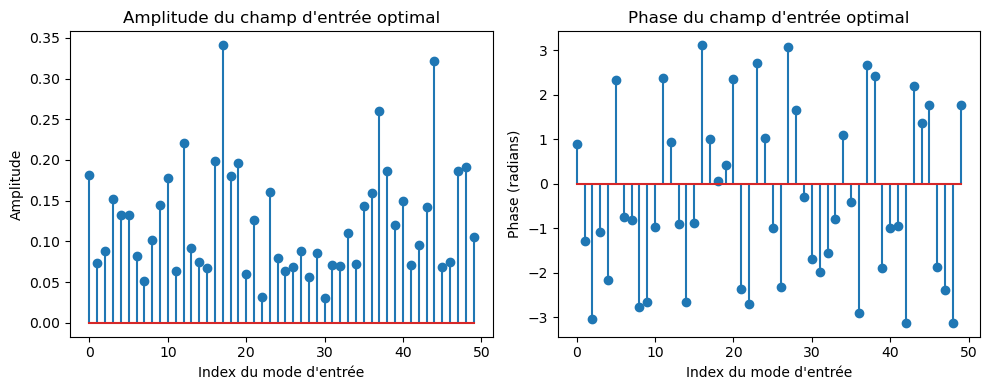

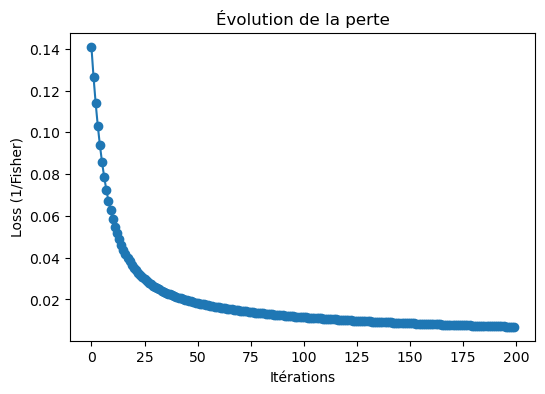

In [24]:
# 3 Optimisation de l'entrée avec PyTorch


class OutputFields(nn.Module):
    def __init__(self, H0, H1, Xinit=None):
        super().__init__()
        n_out, n_in = H0.shape
        if Xinit is None:
            X = torch.randn(n_in, dtype=torch.cfloat)
            X = X / torch.sum(torch.abs(X)**2)
        else:
            X = torch.tensor(Xinit, dtype=torch.cfloat)
        self.X = nn.Parameter(X, requires_grad=True)
        self.H0 = torch.tensor(H0, dtype=torch.cfloat)
        self.H1 = torch.tensor(H1, dtype=torch.cfloat)
       
    def forward(self):
        Xnorm = self.X / torch.sqrt(torch.sum(torch.abs(self.X)**2))
        Y0 = self.H0 @ Xnorm
        Y1 = self.H1 @ Xnorm
        return Y0, Y1

def fisher_opt_opm(Y0, Y1):
    Ymat1 = Y1[:, None] * Y1[None, :].conj()
    Ymat0 = Y0[:, None] * Y0[None, :].conj()
    L, _ = torch.linalg.eigh(Ymat1 - Ymat0)
    return 1 / torch.sum(L**2)

def optimize_inputNopms(Xinit, TMs, n_epochs=200, lr=1e-2):
    model = OutputFields(TMs[0], TMs[1], Xinit=Xinit)
    loss_fn = fisher_opt_opm
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_evol = []
    for epoch in range(n_epochs):
        Y0, Y1 = model()
        loss = loss_fn(Y0, Y1)
        loss_evol.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    X_final = model.state_dict()['X'].numpy()
    X_final /= np.sqrt(np.sum(np.abs(X_final)**2))
    return X_final, loss_evol

# Initialisation de Xinit, le vecteur d'entrée que l'on va optimiser par rapport a l'intensité de sortie, pour Nb_input_modes, le premier mode étant aléatoire 
Xinit = np.random.randn(Nb_input_modes) + 1j*np.random.randn(Nb_input_modes)
Xopt, loss_evol = optimize_inputNopms(Xinit, TMs4modes, n_epochs=200, lr=1e-2)
Fopt = fisher(Xopt , TMs4modes)
Fopt_normalise = Fopt / Fnorm_fac
print ( 'fisher_opt = ' , Fopt_normalise)
# no tensors tests tms4 modes

# Affichage du champ d'entrée optimal
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.stem(np.abs(Xopt))
plt.xlabel("Index du mode d'entrée")
plt.ylabel("Amplitude")
plt.title("Amplitude du champ d'entrée optimal")

plt.subplot(1,2,2)
plt.stem(np.angle(Xopt))
plt.xlabel("Index du mode d'entrée")
plt.ylabel("Phase (radians)")
plt.title("Phase du champ d'entrée optimal")

plt.tight_layout()
plt.show()


plt.figure(figsize=(6,4))
plt.plot(loss_evol, 'o-')
plt.xlabel("Itérations")
plt.ylabel("Loss (1/Fisher)")
plt.title("Évolution de la perte")
plt.show()


fisher_opt =  22.738326192801615


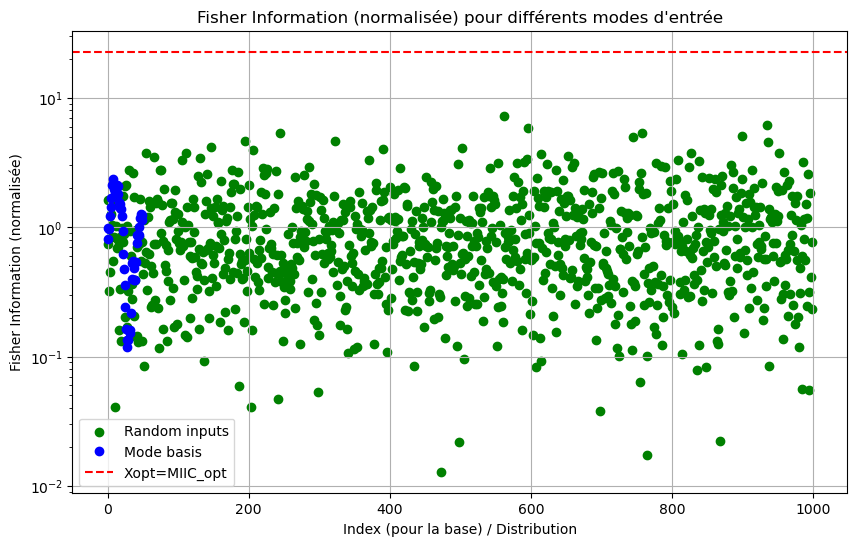

In [28]:
# Comparaison des différentes Fisher Information pour différents modes d'entrée ( aleat, can, opti)


Nb_input_modes = TMs4modes.shape[2]

# On suppose que 'fisher' est une fonction qui, pour un ensemble d'entrées X (chaque ligne un vecteur),
# et pour un ensemble de TM (ici TMs4modes avec les 2 états : référence et calibration),
# renvoie la Fisher information associée à chaque vecteur d'entrée.
n_rnd = 1000
# Génération de n_rnd vecteurs complexes aléatoires de dimension Nb_input_modes
Xrnd = np.random.randn(n_rnd, Nb_input_modes) + 1j * np.random.randn(n_rnd, Nb_input_modes)
# Normalisation de chaque vecteur (sur la norme L2)
Xrnd = Xrnd / np.sqrt(np.sum(np.abs(Xrnd)**2, axis=1, keepdims=True))

# Pour la base canonique (mode basis), on prend l'identité de taille Nb_input_modes
Xmod = np.eye(Nb_input_modes, dtype=complex)

# Calcul de la Fisher information pour les random inputs et la base canonique
Frnd = fisher(Xrnd, TMs4modes)    # Frnd est un tableau de forme (n_rnd,)
Fmod = fisher(Xmod, TMs4modes)      # Fmod est un vecteur de taille (Nb_input_modes,)

# Pour faciliter la comparaison, on normalise toutes ces valeurs par la moyenne des random inputs.
Fnorm_fac = np.mean(Frnd)
Frnd_norm = Frnd / Fnorm_fac
Fmod_norm = Fmod / Fnorm_fac
#Fmiic_norm = Fmiic / Fnorm_fac
Fopt = fisher(Xopt , TMs4modes)
Fopt_normalise = Fopt / Fnorm_fac
print ( 'fisher_opt = ' , Fopt_normalise)

# Affichage graphique :
plt.figure(figsize=(10,6))

# Afficher l'histogramme de la Fisher information pour les random inputs
plt.scatter(np.arange(len(Frnd_norm)), Frnd_norm, color='g', label='Random inputs')

# Tracer les Fisher information pour la base canonique
plt.plot(np.arange(Nb_input_modes), Fmod_norm, 'o', color='b', label='Mode basis')

# Tracer une ligne horizontale pour la valeur du MIIC (non optimisé donc on enlève)
#plt.axhline(Fmiic_norm, linestyle='--', color='r', label='MIIC')

plt.axhline(Fopt_normalise, linestyle='--', color='r', label='Xopt=MIIC_opt')

plt.yscale("log")
plt.title('Fisher Information (normalisée) pour différents modes d\'entrée')
plt.xlabel('Index (pour la base) / Distribution')
plt.ylabel('Fisher Information (normalisée)')
plt.legend()
plt.grid(True)
plt.show()
